**Results for misspecified gamma experiments**

In [389]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd

In [390]:
mlflow.set_tracking_uri('http://localhost:3336')
client = MlflowClient()

model_names = ['Efficient', 'DR']
experiment_names = ['Synthetic_'+ model_name for model_name in model_names]
experiments = {exp.name: exp.experiment_id for exp in client.search_experiments()}

In [391]:
metric_names = ['regret']
param_names = ['global_seed', 'gamma', 'gamma_data', 'n_samples_train']
data_dict = {}

for experiment_name in experiment_names:
    if experiment_name in experiments:
        experiment_id = experiments[experiment_name]
        # Get all runs for the experiment
        runs = client.search_runs(experiment_ids=[experiment_id])
        # Extract metrics and parameters
        runs_data = [
            {
                **run.data.metrics,
                **run.data.params,
                'run_id': run.info.run_id
            }
            for run in runs
        ]
        combined_df = pd.DataFrame(runs_data)
        
        if not combined_df.empty:
            # Filter the DataFrame to only include the desired metrics and parameters
            columns_to_include = ['run_id'] + metric_names + param_names
            filtered_df = combined_df[columns_to_include]
            data_dict[experiment_name.split("/")[0]] = filtered_df
        else:
            print(f"No runs found for experiment {experiment_name}.")
    else:
        print(f"Experiment {experiment_name} does not exist.")


efficient_estimator = data_dict['Synthetic_Efficient'].drop(columns=['run_id'])
dr_estimator = data_dict['Synthetic_DR'].drop(columns=['run_id'])

efficient_estimator['regret'] = pd.to_numeric(efficient_estimator['regret'], errors='coerce')
dr_estimator['regret'] = pd.to_numeric(dr_estimator['regret'], errors='coerce')

efficient_estimator['gamma'] = pd.to_numeric(efficient_estimator['gamma'], errors='coerce')
dr_estimator['gamma'] = pd.to_numeric(dr_estimator['gamma'], errors='coerce')


efficient_estimator['gamma_data'] = pd.to_numeric(efficient_estimator['gamma_data'], errors='coerce')
dr_estimator['gamma_data'] = pd.to_numeric(dr_estimator['gamma_data'], errors='coerce')

efficient_estimator['n_samples_train'] = pd.to_numeric(efficient_estimator['n_samples_train'], errors='coerce')
dr_estimator['n_samples_train'] = pd.to_numeric(dr_estimator['n_samples_train'], errors='coerce')


**Compute mean and standard deviation of regret over randomized policy** 

In [392]:
efficient_mean = efficient_estimator.groupby('gamma')['regret'].mean()
efficient_std = efficient_estimator.groupby('gamma')['regret'].std()

dr_mean = dr_estimator.groupby('gamma')['regret'].mean()
dr_std = dr_estimator.groupby('gamma')['regret'].std()

**Plot the results**

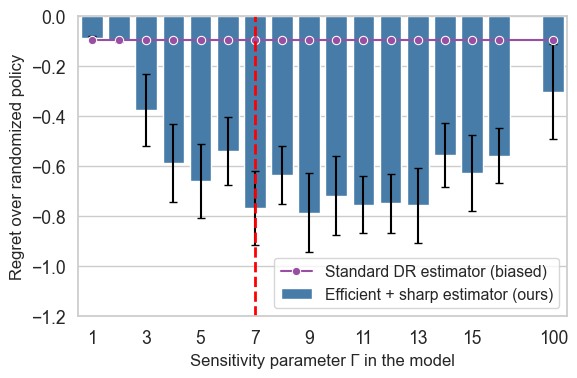

In [397]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame to store all data for plotting
df = pd.DataFrame({
    'Gamma': efficient_mean.index,
    'Efficient_Mean': efficient_mean.values,
    'Efficient_Std': efficient_std.values,
    'DR_Mean': np.asarray(np.stack([dr_mean.values] * 21, axis=0).tolist())[:, 0],
    'DR_Std': np.asarray(np.stack([dr_std.values] * 21, axis=0).tolist())[:, 0]
})

# Filter data for Gamma = 1 to 16 and 100
filtered_df = df[(df['Gamma'] <= 16) | (df['Gamma'] == 100)]

# Prepare data for plotting
efficient = filtered_df[['Gamma', 'Efficient_Mean', 'Efficient_Std']].rename(
    columns={'Efficient_Mean': 'Mean', 'Efficient_Std': 'Std'}
)
efficient['Model'] = 'Efficient + sharp estimator (ours)'
efficient['Std'] = efficient['Std'] / np.sqrt(10)  # Standard error adjustment

# Prepare DR data for plotting
dr = filtered_df[['Gamma', 'DR_Mean', 'DR_Std']].rename(
    columns={'DR_Mean': 'Mean', 'DR_Std': 'Std'}
)
dr['Model'] = 'DR estimator (biased)'

# Combine both data for plotting
plot_data = pd.concat([efficient, dr])

# Add a placeholder for Gamma values with a blank space between 16 and 100
x_labels = list(range(1, 17)) + [''] + [100]  # Explicit x-labels with a blank space
x_labels = [str(x) for x in x_labels]  # Convert all labels to strings for consistency

plot_data['Gamma'] = plot_data['Gamma'].astype(str)  # Ensure Gamma is a string

# Create a categorical column for proper ordering, including the blank space
plot_data['Gamma'] = pd.Categorical(
    plot_data['Gamma'], categories=x_labels, ordered=True
)

# Seaborn color palette
palette = sns.color_palette("Set1", n_colors=4)

# Create the plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=plot_data[plot_data['Model'] == 'Efficient + sharp estimator (ours)'],
    x='Gamma',
    y='Mean',
    color=palette[1],
    errorbar=None,
    label='Efficient + sharp estimator (ours)'
)

# Add error bars for Efficient estimator
# Align error bars with the bar positions
x_positions = [x_labels.index(gamma) for gamma in plot_data[plot_data['Model'] == 'Efficient + sharp estimator (ours)']['Gamma']]
y_values = plot_data[plot_data['Model'] == 'Efficient + sharp estimator (ours)']['Mean']
y_errors = plot_data[plot_data['Model'] == 'Efficient + sharp estimator (ours)']['Std']

plt.errorbar(
    x=x_positions,
    y=y_values,
    yerr=y_errors,
    fmt='none',
    c='black',
    capsize=3,
    label=None
)

# Add DR estimator line plot
sns.lineplot(
    data=plot_data[plot_data['Model'] == 'DR estimator (biased)'],
    x='Gamma',
    y='Mean',
    color=palette[3],
    marker='o',
    label='Standard DR estimator (biased)'
)

# Add a vertical line at Gamma = 7
plt.axvline(x=x_labels.index('7'), color='red', linestyle='--', linewidth=2)

# Customize ticks for Gamma
plt.xticks(
    ticks=range(len(x_labels)),
    labels=x_labels
)

# Customize ticks for Gamma
# Set ticks only for specific Gamma values
desired_ticks = ['1', '3', '5', '7', '9', '11', '13', '15', '100']
plt.xticks(
    ticks=[x_labels.index(gamma) for gamma in desired_ticks],
    labels=desired_ticks
)

# Adjust margins and labels
plt.ylim(-1.2, 0)
plt.xlim(-0.5, 17.5)
plt.xlabel('Sensitivity parameter Г in the model', fontsize=12)
plt.ylabel('Regret over randomized policy', fontsize=12)
plt.legend(loc='lower right', frameon=True, fontsize=11.3)
plt.tight_layout()

# Show the plot
plt.show()
